# Perform time series forecasting on Google Kubernetes Engine with NVIDIA GPUs

In this example, we will be looking at a real-world example of **time series forecasting** with data from [the M5 Forecasting Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy). Walmart provides historical sales data from multiple stores in three states, and our job is to predict the sales in a future 28-day period.

## Prerequisites

### Prepare GKE cluster

To run the example, you will need a working Google Kubernetes Engine (GKE) cluster with access to NVIDIA GPUs.

````{docref} /cloud/gcp/gke
Set up a Google Kubernetes Engine (GKE) cluster with access to NVIDIA GPUs. Follow instructions in [Google Kubernetes Engine](../../cloud/gcp/gke).
````

1. To ensure that the example runs smoothly, ensure that you have ample memory in your GPUs. This notebook has been tested with NVIDIA A100.

2. Set up Dask-Kubernetes integration by following instructions in the following guides:

  * [Install the Dask-Kubernetes operator](https://kubernetes.dask.org/en/latest/operator_installation.html)
  * [Install Kubeflow](https://www.kubeflow.org/docs/started/installing-kubeflow/)

Kubeflow is not strictly necessary, but we highly recommend it, as Kubeflow gives you a nice notebook environment to run this notebook within the k8s cluster. (You may choose any method; we tested this example after installing Kubeflow from manifests.) When creating the notebook environment, use the following configuration:

* 2 CPUs, 16 GiB of memory
* 1 NVIDIA GPU
* 40 GiB disk volume

After uploading all the notebooks in the example, run this notebook (`notebook.ipynb`) in the notebook environment.

Note: We will use the worker pods to speed up the training stage. The preprocessing steps will run solely on the scheduler node.

### Prepare a bucket in Google Cloud Storage

Create a new bucket in Google Cloud Storage. Make sure that the worker pods in the k8s cluster has read/write access to this bucket. This can be done in one of the following methods:

1. Option 1: Specify an additional scope when provisioning the GKE cluster.

   When you are provisioning a new GKE cluster, add the `storage-rw` scope.
   This option is only available if you are creating a new cluster from scratch. If you are using an exising GKE cluster, see Option 2.

   Example:
```
gcloud container clusters create my_new_cluster --accelerator type=nvidia-tesla-t4 \
   --machine-type n1-standard-32 --zone us-central1-c --release-channel stable \
   --num-nodes 5 --scopes=gke-default,storage-rw
```

2. Option 2: Grant bucket access to the associated service account.

   Find out which service account is associated with your GKE cluster. You can grant the bucket access to the service account as follows: Nagivate to the Cloud Storage console, open the Bucket Details page for the bucket, open the Permissions tab, and click on Grant Access.
   
Enter the name of the bucket that your cluster has read-write access to:

In [1]:
bucket_name = "<Put the name of the bucket here>"

### Install Python packages in the notebook environment

In [ ]:
!pip install kaggle gcsfs dask-kubernetes optuna

In [3]:
# Test if the bucket is accessible
import gcsfs

fs = gcsfs.GCSFileSystem()
fs.ls(f"{bucket_name}/")

[]

## Obtain the time series data set from Kaggle

If you do not yet have an account with Kaggle, create one now. Then follow instructions in [Public API Documentation of Kaggle](https://www.kaggle.com/docs/api) to obtain the API key. This step is needed to obtain the training data from the M5 Forecasting Competition. Once you obtained the API key, fill in the following:

In [4]:
kaggle_username = "<Put your Kaggle username here>"
kaggle_api_key = "<Put your Kaggle API key here>"

Now we are ready to download the data set:

In [ ]:
%env KAGGLE_USERNAME=$kaggle_username
%env KAGGLE_KEY=$kaggle_api_key

!kaggle competitions download -c m5-forecasting-accuracy

Let's unzip the ZIP archive and see what's inside.

In [6]:
import zipfile

with zipfile.ZipFile("m5-forecasting-accuracy.zip", "r") as zf:
    zf.extractall(path="./data")

In [7]:
!ls -lh data/*.csv

-rw-r--r-- 1 rapids conda 102K Sep 28 18:59 data/calendar.csv
-rw-r--r-- 1 rapids conda 117M Sep 28 18:59 data/sales_train_evaluation.csv
-rw-r--r-- 1 rapids conda 115M Sep 28 18:59 data/sales_train_validation.csv
-rw-r--r-- 1 rapids conda 5.0M Sep 28 18:59 data/sample_submission.csv
-rw-r--r-- 1 rapids conda 194M Sep 28 18:59 data/sell_prices.csv


## Data preprocessing

We are now ready to run the preprocessing steps.

### Import modules and define utility functions

In [8]:
import cudf
import numpy as np
import gc
import pathlib
import gcsfs


def sizeof_fmt(num, suffix="B"):
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return "%.1f%s%s" % (num, "Yi", suffix)


def report_dataframe_size(df, name):
    print(
        "{} takes up {} memory on GPU".format(
            name, sizeof_fmt(grid_df.memory_usage(index=True).sum())
        )
    )

### Load Data

In [9]:
TARGET = "sales"  # Our main target
END_TRAIN = 1941  # Last day in train set

In [10]:
raw_data_dir = pathlib.Path("./data/")

In [11]:
train_df = cudf.read_csv(raw_data_dir / "sales_train_evaluation.csv")
prices_df = cudf.read_csv(raw_data_dir / "sell_prices.csv")
calendar_df = cudf.read_csv(raw_data_dir / "calendar.csv").rename(
    columns={"d": "day_id"}
)

In [12]:
train_df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


The columns `d_1`, `d_2`, ..., `d_1941` indicate the sales data at days 1, 2, ..., 1941 from 2011-01-29.

In [13]:
prices_df

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [14]:
calendar_df

,date,wm_yr_wk,weekday,wday,month,year,day_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,<NA>,<NA>,<NA>,<NA>,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,<NA>,<NA>,<NA>,<NA>,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,<NA>,<NA>,<NA>,<NA>,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,<NA>,<NA>,<NA>,<NA>,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,<NA>,<NA>,<NA>,<NA>,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,<NA>,<NA>,<NA>,<NA>,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,<NA>,<NA>,<NA>,<NA>,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,<NA>,<NA>,<NA>,<NA>,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,<NA>,<NA>,<NA>,<NA>,0,0,0


### Reformat sales times series data

Pivot the columns `d_1`, `d_2`, ..., `d_1941` into separate rows using `cudf.melt`.

In [15]:
index_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
grid_df = cudf.melt(
    train_df, id_vars=index_columns, var_name="day_id", value_name=TARGET
)
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0


For each time series, add 28 rows that corresponds to the future forecast horizon:

In [16]:
add_grid = cudf.DataFrame()
for i in range(1, 29):
    temp_df = train_df[index_columns]
    temp_df = temp_df.drop_duplicates()
    temp_df["day_id"] = "d_" + str(END_TRAIN + i)
    temp_df[TARGET] = np.nan  # Sales amount at time (n + i) is unknown
    add_grid = cudf.concat([add_grid, temp_df])
add_grid["day_id"] = add_grid["day_id"].astype(
    "category"
)  # The day_id column is categorical, after cudf.melt

grid_df = cudf.concat([grid_df, add_grid])
grid_df = grid_df.reset_index(drop=True)
grid_df["sales"] = grid_df["sales"].astype(
    np.float32
)  # Use float32 type for sales column, to conserve memory
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,NaN
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,NaN
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,NaN
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,NaN


### Free up GPU memory

GPU memory is a precious resource, so let's try to free up some memory. First, delete temporary variables we no longer need:

In [17]:
# Use xdel magic to scrub extra references from Jupyter notebook
%xdel temp_df
%xdel add_grid
%xdel train_df

# Invoke the garbage collector explicitly to free up memory
gc.collect()

8136

Second, let's reduce the footprint of `grid_df` by converting strings into categoricals:

In [18]:
report_dataframe_size(grid_df, "grid_df")

grid_df takes up 5.2GiB memory on GPU


In [19]:
grid_df.dtypes

id            object
item_id       object
dept_id       object
cat_id        object
store_id      object
state_id      object
day_id      category
sales        float32
dtype: object

In [20]:
for col in index_columns:
    grid_df[col] = grid_df[col].astype("category")
    gc.collect()
report_dataframe_size(grid_df, "grid_df")

grid_df takes up 802.6MiB memory on GPU


In [21]:
grid_df.dtypes

id          category
item_id     category
dept_id     category
cat_id      category
store_id    category
state_id    category
day_id      category
sales        float32
dtype: object

### Identify the release week of each product

Each row in the `prices_df` table contains the price of a product sold at a store for a given week.

In [22]:
prices_df

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


Notice that not all products were sold over every week. Some products were sold only during some weeks. Let's use the groupby operation to identify the first week in which each product went on the shelf.

In [23]:
release_df = (
    prices_df.groupby(["store_id", "item_id"])["wm_yr_wk"].agg("min").reset_index()
)
release_df.columns = ["store_id", "item_id", "release_week"]
release_df

,store_id,item_id,release_week
0,CA_4,FOODS_3_529,11421
1,TX_1,HOUSEHOLD_1_409,11230
2,WI_2,FOODS_3_145,11214
3,CA_4,HOUSEHOLD_1_494,11106
4,WI_3,HOBBIES_1_093,11223
...,...,...,...
30485,CA_3,HOUSEHOLD_1_369,11205
30486,CA_2,FOODS_3_109,11101
30487,CA_4,FOODS_2_119,11101
30488,CA_4,HOUSEHOLD_2_384,11110


Now that we've computed the release week for each product, let's merge it back to `grid_df`:

In [24]:
grid_df = grid_df.merge(release_df, on=["store_id", "item_id"], how="left")
grid_df = grid_df.sort_values(index_columns + ["day_id"]).reset_index(drop=True)
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,release_week
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3.0,11101
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0.0,11101
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0.0,11101
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1.0,11101
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4.0,11101
...,...,...,...,...,...,...,...,...,...
60034805,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1965,NaN,11101
60034806,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1966,NaN,11101
60034807,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1967,NaN,11101
60034808,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1968,NaN,11101


In [25]:
del release_df  # No longer needed
gc.collect()

139

In [26]:
report_dataframe_size(grid_df, "grid_df")

grid_df takes up 1.2GiB memory on GPU


### Filter out entries with zero sales

We can further save space by dropping rows from `grid_df` that correspond to zero sales. Since each product doesn't go on the shelf until its release week, its sale must be zero during any week that's prior to the release week.

To make use of this insight, we bring in the `wm_yr_wk` column from `calendar_df`:

In [27]:
grid_df = grid_df.merge(calendar_df[["wm_yr_wk", "day_id"]], on=["day_id"], how="left")
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,release_week,wm_yr_wk
0,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_809,0.0,11101,11312
1,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_810,0.0,11101,11312
2,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_811,2.0,11101,11312
3,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_812,0.0,11101,11312
4,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_813,1.0,11101,11313
...,...,...,...,...,...,...,...,...,...,...
60034805,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_52,0.0,11101,11108
60034806,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_53,0.0,11101,11108
60034807,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_54,0.0,11101,11108
60034808,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_55,0.0,11101,11108


In [28]:
report_dataframe_size(grid_df, "grid_df")

grid_df takes up 1.7GiB memory on GPU


The `wm_yr_wk` column identifies the week that contains the day given by the `day_id` column. Now let's filter all rows in `grid_df` for which `wm_yr_wk` is less than `release_week`:

In [29]:
df = grid_df[grid_df["wm_yr_wk"] < grid_df["release_week"]]
df

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,release_week,wm_yr_wk
6766,FOODS_1_002_TX_1_evaluation,FOODS_1_002,FOODS_1,FOODS,TX_1,TX,d_1,0.0,11102,11101
6767,FOODS_1_002_TX_1_evaluation,FOODS_1_002,FOODS_1,FOODS,TX_1,TX,d_2,0.0,11102,11101
19686,FOODS_1_001_TX_3_evaluation,FOODS_1_001,FOODS_1,FOODS,TX_3,TX,d_1,0.0,11102,11101
19687,FOODS_1_001_TX_3_evaluation,FOODS_1_001,FOODS_1,FOODS,TX_3,TX,d_2,0.0,11102,11101
19688,FOODS_1_001_TX_3_evaluation,FOODS_1_001,FOODS_1,FOODS,TX_3,TX,d_3,0.0,11102,11101
...,...,...,...,...,...,...,...,...,...,...
60033493,HOUSEHOLD_2_516_WI_2_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,d_20,0.0,11106,11103
60033494,HOUSEHOLD_2_516_WI_2_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,d_21,0.0,11106,11103
60033495,HOUSEHOLD_2_516_WI_2_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,d_22,0.0,11106,11104
60033496,HOUSEHOLD_2_516_WI_2_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,d_23,0.0,11106,11104


As we suspected, the sales amount is zero during weeks that come before the release week.

In [30]:
assert (df["sales"] == 0).all()

For the purpose of our data analysis, we can safely drop the rows with zero sales:

In [31]:
grid_df = grid_df[grid_df["wm_yr_wk"] >= grid_df["release_week"]].reset_index(drop=True)
grid_df["wm_yr_wk"] = grid_df["wm_yr_wk"].astype(
    np.int32
)  # Convert wm_yr_wk column to int32, to conserve memory
grid_df

,id,item_id,dept_id,cat_id,store_id,state_id,day_id,sales,release_week,wm_yr_wk
0,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_809,0.0,11101,11312
1,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_810,0.0,11101,11312
2,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_811,2.0,11101,11312
3,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_812,0.0,11101,11312
4,FOODS_1_001_WI_2_evaluation,FOODS_1_001,FOODS_1,FOODS,WI_2,WI,d_813,1.0,11101,11313
...,...,...,...,...,...,...,...,...,...,...
47735392,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_52,0.0,11101,11108
47735393,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_53,0.0,11101,11108
47735394,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_54,0.0,11101,11108
47735395,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_55,0.0,11101,11108


In [32]:
report_dataframe_size(grid_df, "grid_df")

grid_df takes up 1.2GiB memory on GPU


### Assign weights for product items

When we assess the accuracy of our machine learning model, we should assign a weight for each product item, to indicate the relative importance of the item. For the M5 competition, the weights are computed from the total sales amount (in US dollars) in the lastest 28 days.

In [33]:
# Convert day_id to integers
grid_df["day_id_int"] = grid_df["day_id"].to_pandas().apply(lambda x: x[2:]).astype(int)

# Compute the total sales over the latest 28 days, per product item
last28 = grid_df[(grid_df["day_id_int"] >= 1914) & (grid_df["day_id_int"] < 1942)]
last28 = last28[["item_id", "wm_yr_wk", "sales"]].merge(
    prices_df[["item_id", "wm_yr_wk", "sell_price"]], on=["item_id", "wm_yr_wk"]
)
last28["sales_usd"] = last28["sales"] * last28["sell_price"]
total_sales_usd = last28.groupby("item_id")[["sales_usd"]].agg(["sum"]).sort_index()
total_sales_usd.columns = total_sales_usd.columns.map("_".join)
total_sales_usd

,sales_usd_sum
item_id,
FOODS_1_001,3516.80
FOODS_1_002,12418.80
FOODS_1_003,5943.20
FOODS_1_004,54184.82
FOODS_1_005,17877.00
...,...
HOUSEHOLD_2_512,6034.40
HOUSEHOLD_2_513,2668.80
HOUSEHOLD_2_514,9574.60


To obtain weights, we normalize the sales amount for one item by the total sales for all items.

In [34]:
weights = total_sales_usd / total_sales_usd.sum()
weights = weights.rename(columns={"sales_usd_sum": "weights"})
weights

,weights
item_id,
FOODS_1_001,0.000090
FOODS_1_002,0.000318
FOODS_1_003,0.000152
FOODS_1_004,0.001389
FOODS_1_005,0.000458
...,...
HOUSEHOLD_2_512,0.000155
HOUSEHOLD_2_513,0.000068
HOUSEHOLD_2_514,0.000245


In [35]:
# No longer needed
del grid_df["day_id_int"]

### Generate price-related features
Let us engineer additional features that are related to the sale price. We consider the distribution of the price of a given product over time and ask how the current price compares to the historical trend.

In [36]:
# Highest price over all weeks
prices_df["price_max"] = prices_df.groupby(["store_id", "item_id"])[
    "sell_price"
].transform("max")
# Lowest price over all weeks
prices_df["price_min"] = prices_df.groupby(["store_id", "item_id"])[
    "sell_price"
].transform("min")
# Standard deviation of the price
prices_df["price_std"] = prices_df.groupby(["store_id", "item_id"])[
    "sell_price"
].transform("std")
# Mean (average) price over all weeks
prices_df["price_mean"] = prices_df.groupby(["store_id", "item_id"])[
    "sell_price"
].transform("mean")

We also consider the ratio of the current price to the max price.

In [37]:
prices_df["price_norm"] = prices_df["sell_price"] / prices_df["price_max"]

Some items have a very stable price, whereas other items respond to inflation quickly and rise in price. To capture the price elasticity, we count the number of unique price values for a given product over time.

In [38]:
prices_df["price_nunique"] = prices_df.groupby(["store_id", "item_id"])[
    "sell_price"
].transform("nunique")

We also consider, for a given price, how many other items are being sold at the exact same price.

In [39]:
prices_df["item_nunique"] = prices_df.groupby(["store_id", "sell_price"])[
    "item_id"
].transform("nunique")

In [40]:
prices_df

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,0.152139,8.285714,1.000000,3,3
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,0.152139,8.285714,1.000000,3,3
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,0.152139,8.285714,0.862213,3,5
3,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,0.152139,8.285714,0.862213,3,5
4,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,0.152139,8.285714,0.862213,3,5
...,...,...,...,...,...,...,...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00,1.00,1.00,0.000000,1.000000,1.000000,1,142
6841117,WI_3,FOODS_3_827,11618,1.00,1.00,1.00,0.000000,1.000000,1.000000,1,142
6841118,WI_3,FOODS_3_827,11619,1.00,1.00,1.00,0.000000,1.000000,1.000000,1,142
6841119,WI_3,FOODS_3_827,11620,1.00,1.00,1.00,0.000000,1.000000,1.000000,1,142


Another useful way to put prices in context is to compare the price of a product to its historical price a week ago, a month ago, or an year ago.

In [41]:
# Add "month" and "year" columns to prices_df
week_to_month_map = calendar_df[["wm_yr_wk", "month", "year"]].drop_duplicates(
    subset=["wm_yr_wk"]
)
prices_df = prices_df.merge(week_to_month_map, on=["wm_yr_wk"], how="left")

# Sort by wm_yr_wk. The rows will also be sorted in ascending months and years.
prices_df = prices_df.sort_values(["store_id", "item_id", "wm_yr_wk"])

In [42]:
# Compare with the average price in the previous week
prices_df["price_momentum"] = prices_df["sell_price"] / prices_df.groupby(
    ["store_id", "item_id"]
)["sell_price"].shift(1)
# Compare with the average price in the previous month
prices_df["price_momentum_m"] = prices_df["sell_price"] / prices_df.groupby(
    ["store_id", "item_id", "month"]
)["sell_price"].transform("mean")
# Compare with the average price in the previous year
prices_df["price_momentum_y"] = prices_df["sell_price"] / prices_df.groupby(
    ["store_id", "item_id", "year"]
)["sell_price"].transform("mean")

In [43]:
# Remove "month" and "year" columns, as we don't need them any more
del prices_df["month"], prices_df["year"]

# Convert float64 columns into float32 type to save memory
columns = [
    "sell_price",
    "price_max",
    "price_min",
    "price_std",
    "price_mean",
    "price_norm",
    "price_momentum",
    "price_momentum_m",
    "price_momentum_y",
]
for col in columns:
    prices_df[col] = prices_df[col].astype(np.float32)

In [44]:
prices_df.dtypes

store_id             object
item_id              object
wm_yr_wk              int64
sell_price          float32
price_max           float32
price_min           float32
price_std           float32
price_mean          float32
price_norm          float32
price_nunique         int32
item_nunique          int32
price_momentum      float32
price_momentum_m    float32
price_momentum_y    float32
dtype: object

### Bring in price-related features into `grid_df`

In [45]:
# After merging price_df, keep columns id and day_id from grid_df and drop all other columns from grid_df
original_columns = list(grid_df)
grid_df_with_price = grid_df.copy()
grid_df_with_price = grid_df_with_price.merge(
    prices_df, on=["store_id", "item_id", "wm_yr_wk"], how="left"
)
columns_to_keep = ["id", "day_id"] + [
    col for col in list(grid_df_with_price) if col not in original_columns
]
grid_df_with_price = grid_df_with_price[["id", "day_id"] + columns_to_keep]
grid_df_with_price

,id,day_id,sell_price,price_max,price_min,price_std,price_mean,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
0,FOODS_1_002_TX_3_evaluation,d_362,8.88,9.48,7.88,4.849956e-01,8.935319,0.936709,3,10,1.0,0.976104,1.0
1,FOODS_1_002_TX_3_evaluation,d_363,8.88,9.48,7.88,4.849956e-01,8.935319,0.936709,3,10,1.0,0.976104,1.0
2,FOODS_1_002_TX_3_evaluation,d_364,8.88,9.48,7.88,4.849956e-01,8.935319,0.936709,3,10,1.0,0.976104,1.0
3,FOODS_1_002_TX_3_evaluation,d_365,8.88,9.48,7.88,4.849956e-01,8.935319,0.936709,3,10,1.0,0.976104,1.0
4,FOODS_1_002_TX_3_evaluation,d_366,8.88,9.48,7.88,4.849956e-01,8.935319,0.936709,3,10,1.0,0.976104,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,HOUSEHOLD_2_516_WI_2_evaluation,d_695,5.94,5.94,5.94,3.648122e-14,5.940000,1.000000,1,47,1.0,1.000000,1.0
47735393,HOUSEHOLD_2_516_WI_2_evaluation,d_696,5.94,5.94,5.94,3.648122e-14,5.940000,1.000000,1,47,1.0,1.000000,1.0
47735394,HOUSEHOLD_2_516_WI_2_evaluation,d_690,5.94,5.94,5.94,3.648122e-14,5.940000,1.000000,1,47,1.0,1.000000,1.0
47735395,HOUSEHOLD_2_516_WI_2_evaluation,d_691,5.94,5.94,5.94,3.648122e-14,5.940000,1.000000,1,47,1.0,1.000000,1.0


### Generate date-related features
We identify the date in each row of `grid_df` using information from `calendar_df`.

In [46]:
# Bring in the following columns from calendar_df into grid_df
grid_df_id_only = grid_df[["id", "day_id"]].copy()

icols = [
    "date",
    "day_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
]
grid_df_with_calendar = grid_df_id_only.merge(
    calendar_df[icols], on=["day_id"], how="left"
)
grid_df_with_calendar

,id,day_id,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,FOODS_1_002_WI_3_evaluation,d_1678,2015-09-02,<NA>,<NA>,<NA>,<NA>,1,0,1
1,FOODS_1_002_WI_3_evaluation,d_1679,2015-09-03,<NA>,<NA>,<NA>,<NA>,1,1,1
2,FOODS_1_002_WI_3_evaluation,d_1680,2015-09-04,<NA>,<NA>,<NA>,<NA>,1,0,0
3,FOODS_1_002_WI_3_evaluation,d_1681,2015-09-05,<NA>,<NA>,<NA>,<NA>,1,1,1
4,FOODS_1_002_WI_3_evaluation,d_1682,2015-09-06,<NA>,<NA>,<NA>,<NA>,1,1,1
...,...,...,...,...,...,...,...,...,...,...
47735392,HOUSEHOLD_2_516_WI_2_evaluation,d_977,2013-10-01,<NA>,<NA>,<NA>,<NA>,1,1,0
47735393,HOUSEHOLD_2_516_WI_2_evaluation,d_978,2013-10-02,<NA>,<NA>,<NA>,<NA>,1,0,1
47735394,HOUSEHOLD_2_516_WI_2_evaluation,d_979,2013-10-03,<NA>,<NA>,<NA>,<NA>,1,1,1
47735395,HOUSEHOLD_2_516_WI_3_evaluation,d_903,2013-07-19,<NA>,<NA>,<NA>,<NA>,0,0,0


In [47]:
# Convert columns into categorical type to save memory
for col in [
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
]:
    grid_df_with_calendar[col] = grid_df_with_calendar[col].astype("category")
# Convert "date" column into timestamp type
grid_df_with_calendar["date"] = cudf.to_datetime(grid_df_with_calendar["date"])

Using the `date` column, we can generate related features, such as day, week, or month.

In [48]:
import cupy as cp

grid_df_with_calendar["tm_d"] = grid_df_with_calendar["date"].dt.day.astype(np.int8)
grid_df_with_calendar["tm_w"] = (
    grid_df_with_calendar["date"].dt.isocalendar().week.astype(np.int8)
)
grid_df_with_calendar["tm_m"] = grid_df_with_calendar["date"].dt.month.astype(np.int8)
grid_df_with_calendar["tm_y"] = grid_df_with_calendar["date"].dt.year
grid_df_with_calendar["tm_y"] = (
    grid_df_with_calendar["tm_y"] - grid_df_with_calendar["tm_y"].min()
).astype(np.int8)
grid_df_with_calendar["tm_wm"] = cp.ceil(
    grid_df_with_calendar["tm_d"].to_cupy() / 7
).astype(
    np.int8
)  # which week in tje month?
grid_df_with_calendar["tm_dw"] = grid_df_with_calendar["date"].dt.dayofweek.astype(
    np.int8
)  # which day in the week?
grid_df_with_calendar["tm_w_end"] = (grid_df_with_calendar["tm_dw"] >= 5).astype(
    np.int8
)  # whether today is in the weekend
del grid_df_with_calendar["date"]  # no longer needed

grid_df_with_calendar

,id,day_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,tm_d,tm_w,tm_m,tm_y,tm_wm,tm_dw,tm_w_end
0,FOODS_1_002_WI_3_evaluation,d_1678,<NA>,<NA>,<NA>,<NA>,1,0,1,2,36,9,4,1,2,0
1,FOODS_1_002_WI_3_evaluation,d_1679,<NA>,<NA>,<NA>,<NA>,1,1,1,3,36,9,4,1,3,0
2,FOODS_1_002_WI_3_evaluation,d_1680,<NA>,<NA>,<NA>,<NA>,1,0,0,4,36,9,4,1,4,0
3,FOODS_1_002_WI_3_evaluation,d_1681,<NA>,<NA>,<NA>,<NA>,1,1,1,5,36,9,4,1,5,1
4,FOODS_1_002_WI_3_evaluation,d_1682,<NA>,<NA>,<NA>,<NA>,1,1,1,6,36,9,4,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47735392,HOUSEHOLD_2_516_WI_2_evaluation,d_977,<NA>,<NA>,<NA>,<NA>,1,1,0,1,40,10,2,1,1,0
47735393,HOUSEHOLD_2_516_WI_2_evaluation,d_978,<NA>,<NA>,<NA>,<NA>,1,0,1,2,40,10,2,1,2,0
47735394,HOUSEHOLD_2_516_WI_2_evaluation,d_979,<NA>,<NA>,<NA>,<NA>,1,1,1,3,40,10,2,1,3,0
47735395,HOUSEHOLD_2_516_WI_3_evaluation,d_903,<NA>,<NA>,<NA>,<NA>,0,0,0,19,29,7,2,3,4,0


In [49]:
del grid_df_id_only  # No longer needed
gc.collect()

96

### Generate lag features

**Lag features** are the value of the target variable at prior timestamps. Lag features are useful because what happens in the past often influences what would happen in the future. In our example, we generate lag features by reading the sales amount at X days prior, where X = 28, 29, ..., 42.

In [50]:
SHIFT_DAY = 28
LAG_DAYS = [col for col in range(SHIFT_DAY, SHIFT_DAY + 15)]

# Need to first ensure that rows in each time series are sorted by day_id
grid_df_lags = grid_df[["id", "day_id", "sales"]].copy()
grid_df_lags = grid_df_lags.sort_values(["id", "day_id"])

grid_df_lags = grid_df_lags.assign(
    **{
        f"sales_lag_{l}": grid_df_lags.groupby(["id"])["sales"].shift(l)
        for l in LAG_DAYS
    }
)

In [51]:
grid_df_lags

,id,day_id,sales,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,sales_lag_35,sales_lag_36,sales_lag_37,sales_lag_38,sales_lag_39,sales_lag_40,sales_lag_41,sales_lag_42
34023,FOODS_1_001_CA_1_evaluation,d_1,3.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34024,FOODS_1_001_CA_1_evaluation,d_2,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34025,FOODS_1_001_CA_1_evaluation,d_3,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34026,FOODS_1_001_CA_1_evaluation,d_4,1.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34027,FOODS_1_001_CA_1_evaluation,d_5,4.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47733744,HOUSEHOLD_2_516_WI_3_evaluation,d_1965,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47733745,HOUSEHOLD_2_516_WI_3_evaluation,d_1966,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47733746,HOUSEHOLD_2_516_WI_3_evaluation,d_1967,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47733747,HOUSEHOLD_2_516_WI_3_evaluation,d_1968,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute rolling window statistics

In the previous cell, we used the value of sales at a single timestamp to generate lag features. To capture richer information about the past, let us also get the distribution of the sales value over multiple timestamps, by computing **rolling window statistics**. Rolling window statistics are statistics (e.g. mean, standard deviation) over a time duration in the past. Rolling windows statistics complement lag features and provide more information about the past behavior of the target variable.

Read more about lag features and rolling window statistics in [Introduction to feature engineering for time series forecasting](https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0).

In [52]:
# Shift by 28 days and apply windows of various sizes
print(f"Shift size: {SHIFT_DAY}")
for i in [7, 14, 30, 60, 180]:
    print(f"    Window size: {i}")
    grid_df_lags[f"rolling_mean_{i}"] = (
        grid_df_lags.groupby(["id"])["sales"]
        .shift(SHIFT_DAY)
        .rolling(i)
        .mean()
        .astype(np.float32)
    )
    grid_df_lags[f"rolling_std_{i}"] = (
        grid_df_lags.groupby(["id"])["sales"]
        .shift(SHIFT_DAY)
        .rolling(i)
        .std()
        .astype(np.float32)
    )

Shift size: 28
    Window size: 7
    Window size: 14
    Window size: 30
    Window size: 60
    Window size: 180


In [53]:
grid_df_lags.columns

Index(['id', 'day_id', 'sales', 'sales_lag_28', 'sales_lag_29', 'sales_lag_30',
       'sales_lag_31', 'sales_lag_32', 'sales_lag_33', 'sales_lag_34',
       'sales_lag_35', 'sales_lag_36', 'sales_lag_37', 'sales_lag_38',
       'sales_lag_39', 'sales_lag_40', 'sales_lag_41', 'sales_lag_42',
       'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14',
       'rolling_mean_30', 'rolling_std_30', 'rolling_mean_60',
       'rolling_std_60', 'rolling_mean_180', 'rolling_std_180'],
      dtype='object')

In [54]:
grid_df_lags.dtypes

id                  category
day_id              category
sales                float32
sales_lag_28         float32
sales_lag_29         float32
sales_lag_30         float32
sales_lag_31         float32
sales_lag_32         float32
sales_lag_33         float32
sales_lag_34         float32
sales_lag_35         float32
sales_lag_36         float32
sales_lag_37         float32
sales_lag_38         float32
sales_lag_39         float32
sales_lag_40         float32
sales_lag_41         float32
sales_lag_42         float32
rolling_mean_7       float32
rolling_std_7        float32
rolling_mean_14      float32
rolling_std_14       float32
rolling_mean_30      float32
rolling_std_30       float32
rolling_mean_60      float32
rolling_std_60       float32
rolling_mean_180     float32
rolling_std_180      float32
dtype: object

In [55]:
grid_df_lags

,id,day_id,sales,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31,sales_lag_32,sales_lag_33,sales_lag_34,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180
34023,FOODS_1_001_CA_1_evaluation,d_1,3.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34024,FOODS_1_001_CA_1_evaluation,d_2,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34025,FOODS_1_001_CA_1_evaluation,d_3,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34026,FOODS_1_001_CA_1_evaluation,d_4,1.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
34027,FOODS_1_001_CA_1_evaluation,d_5,4.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47733744,HOUSEHOLD_2_516_WI_3_evaluation,d_1965,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.142857149,0.377964467,0.071428575,0.267261237,0.06666667,0.253708124,0.033333335,0.181020334,0.077777781,0.288621366
47733745,HOUSEHOLD_2_516_WI_3_evaluation,d_1966,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857149,0.377964467,0.071428575,0.267261237,0.06666667,0.253708124,0.033333335,0.181020334,0.077777781,0.288621366
47733746,HOUSEHOLD_2_516_WI_3_evaluation,d_1967,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.142857149,0.377964467,0.071428575,0.267261237,0.06666667,0.253708124,0.033333335,0.181020334,0.077777781,0.288621366
47733747,HOUSEHOLD_2_516_WI_3_evaluation,d_1968,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.071428575,0.267261237,0.06666667,0.253708124,0.033333335,0.181020334,0.077777781,0.288621366


### Target encoding
Categorical variables present challenges to many machine learning algorithms such as XGBoost. One way to overcome the challenge is to use **target encoding**, where we encode categorical variables by replacing them with a statistic for the target variable. In this example, we will use the mean and the standard deviation.

Read more about target encoding in [Target-encoding Categorical Variables](https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69).

In [56]:
icols = [["store_id", "dept_id"], ["item_id", "state_id"]]
new_columns = []

grid_df_target_enc = grid_df[
    ["id", "day_id", "item_id", "state_id", "store_id", "dept_id", "sales"]
].copy()
grid_df_target_enc["sales"].fillna(value=0, inplace=True)

for col in icols:
    print(f"Encoding columns {col}")
    col_name = "_" + "_".join(col) + "_"
    grid_df_target_enc["enc" + col_name + "mean"] = (
        grid_df_target_enc.groupby(col)["sales"].transform("mean").astype(np.float32)
    )
    grid_df_target_enc["enc" + col_name + "std"] = (
        grid_df_target_enc.groupby(col)["sales"].transform("std").astype(np.float32)
    )
    new_columns.extend(["enc" + col_name + "mean", "enc" + col_name + "std"])

Encoding columns ['store_id', 'dept_id']
Encoding columns ['item_id', 'state_id']


In [57]:
grid_df_target_enc = grid_df_target_enc[["id", "day_id"] + new_columns]
grid_df_target_enc

,id,day_id,enc_store_id_dept_id_mean,enc_store_id_dept_id_std,enc_item_id_state_id_mean,enc_item_id_state_id_std
0,FOODS_1_001_WI_2_evaluation,d_809,1.492988,3.987657,0.433553,0.851153
1,FOODS_1_001_WI_2_evaluation,d_810,1.492988,3.987657,0.433553,0.851153
2,FOODS_1_001_WI_2_evaluation,d_811,1.492988,3.987657,0.433553,0.851153
3,FOODS_1_001_WI_2_evaluation,d_812,1.492988,3.987657,0.433553,0.851153
4,FOODS_1_001_WI_2_evaluation,d_813,1.492988,3.987657,0.433553,0.851153
...,...,...,...,...,...,...
47735392,HOUSEHOLD_2_516_WI_3_evaluation,d_52,0.257027,0.661541,0.082084,0.299445
47735393,HOUSEHOLD_2_516_WI_3_evaluation,d_53,0.257027,0.661541,0.082084,0.299445
47735394,HOUSEHOLD_2_516_WI_3_evaluation,d_54,0.257027,0.661541,0.082084,0.299445
47735395,HOUSEHOLD_2_516_WI_3_evaluation,d_55,0.257027,0.661541,0.082084,0.299445


In [58]:
grid_df_target_enc.dtypes

id                           category
day_id                       category
enc_store_id_dept_id_mean     float32
enc_store_id_dept_id_std      float32
enc_item_id_state_id_mean     float32
enc_item_id_state_id_std      float32
dtype: object

### Filter by store and product department and create data segments
After combining all columns produced in the previous notebooks, we filter the rows in the data set by `store_id` and `dept_id` and create a segment. Each segment is saved as a pickle file and then upload to Cloud Storage.

In [59]:
segmented_data_dir = pathlib.Path("./segmented_data/")
segmented_data_dir.mkdir(exist_ok=True)

STORES = [
    "CA_1",
    "CA_2",
    "CA_3",
    "CA_4",
    "TX_1",
    "TX_2",
    "TX_3",
    "WI_1",
    "WI_2",
    "WI_3",
]
DEPTS = [
    "HOBBIES_1",
    "HOBBIES_2",
    "HOUSEHOLD_1",
    "HOUSEHOLD_2",
    "FOODS_1",
    "FOODS_2",
    "FOODS_3",
]

grid2_colnm = [
    "sell_price",
    "price_max",
    "price_min",
    "price_std",
    "price_mean",
    "price_norm",
    "price_nunique",
    "item_nunique",
    "price_momentum",
    "price_momentum_m",
    "price_momentum_y",
]

grid3_colnm = [
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "tm_d",
    "tm_w",
    "tm_m",
    "tm_y",
    "tm_wm",
    "tm_dw",
    "tm_w_end",
]

lag_colnm = [
    "sales_lag_28",
    "sales_lag_29",
    "sales_lag_30",
    "sales_lag_31",
    "sales_lag_32",
    "sales_lag_33",
    "sales_lag_34",
    "sales_lag_35",
    "sales_lag_36",
    "sales_lag_37",
    "sales_lag_38",
    "sales_lag_39",
    "sales_lag_40",
    "sales_lag_41",
    "sales_lag_42",
    "rolling_mean_7",
    "rolling_std_7",
    "rolling_mean_14",
    "rolling_std_14",
    "rolling_mean_30",
    "rolling_std_30",
    "rolling_mean_60",
    "rolling_std_60",
    "rolling_mean_180",
    "rolling_std_180",
]

target_enc_colnm = [
    "enc_store_id_dept_id_mean",
    "enc_store_id_dept_id_std",
    "enc_item_id_state_id_mean",
    "enc_item_id_state_id_std",
]

In [60]:
def prepare_data(store, dept=None):
    """
    Filter and clean data according to stores and product departments

    Parameters
    ----------
    store: Filter data by retaining rows whose store_id matches this parameter.
    dept: Filter data by retaining rows whose dept_id matches this parameter.
          This parameter can be set to None to indicate that we shouldn't filter by dept_id.
    """
    if store is None:
        raise ValueError(f"store parameter must not be None")

    if dept is None:
        grid1 = grid_df[grid_df["store_id"] == store]
    else:
        grid1 = grid_df[
            (grid_df["store_id"] == store) & (grid_df["dept_id"] == dept)
        ].drop(columns=["dept_id"])
    grid1 = grid1.drop(columns=["release_week", "wm_yr_wk", "store_id", "state_id"])

    grid2 = grid_df_with_price[["id", "day_id"] + grid2_colnm]
    grid_combined = grid1.merge(grid2, on=["id", "day_id"], how="left")
    del grid1, grid2

    grid3 = grid_df_with_calendar[["id", "day_id"] + grid3_colnm]
    grid_combined = grid_combined.merge(grid3, on=["id", "day_id"], how="left")
    del grid3

    lag_df = grid_df_lags[["id", "day_id"] + lag_colnm]
    grid_combined = grid_combined.merge(lag_df, on=["id", "day_id"], how="left")
    del lag_df

    target_enc_df = grid_df_target_enc[["id", "day_id"] + target_enc_colnm]
    grid_combined = grid_combined.merge(target_enc_df, on=["id", "day_id"], how="left")
    del target_enc_df
    gc.collect()

    grid_combined = grid_combined.drop(columns=["id"])
    grid_combined["day_id"] = (
        grid_combined["day_id"]
        .to_pandas()
        .astype("str")
        .apply(lambda x: x[2:])
        .astype(np.int16)
    )

    return grid_combined

In [61]:
# First save the segment to the disk
for store in STORES:
    print(f"Processing store {store}...")
    segment_df = prepare_data(store=store)
    segment_df.to_pandas().to_pickle(
        segmented_data_dir / f"combined_df_store_{store}.pkl"
    )
    del segment_df
    gc.collect()

for store in STORES:
    for dept in DEPTS:
        print(f"Processing (store {store}, department {dept})...")
        segment_df = prepare_data(store=store, dept=dept)
        segment_df.to_pandas().to_pickle(
            segmented_data_dir / f"combined_df_store_{store}_dept_{dept}.pkl"
        )
        del segment_df
        gc.collect()

Processing store CA_1...
Processing store CA_2...
Processing store CA_3...
Processing store CA_4...
Processing store TX_1...
Processing store TX_2...
Processing store TX_3...
Processing store WI_1...
Processing store WI_2...
Processing store WI_3...
Processing (store CA_1, department HOBBIES_1)...
Processing (store CA_1, department HOBBIES_2)...
Processing (store CA_1, department HOUSEHOLD_1)...
Processing (store CA_1, department HOUSEHOLD_2)...
Processing (store CA_1, department FOODS_1)...
Processing (store CA_1, department FOODS_2)...
Processing (store CA_1, department FOODS_3)...
Processing (store CA_2, department HOBBIES_1)...
Processing (store CA_2, department HOBBIES_2)...
Processing (store CA_2, department HOUSEHOLD_1)...
Processing (store CA_2, department HOUSEHOLD_2)...
Processing (store CA_2, department FOODS_1)...
Processing (store CA_2, department FOODS_2)...
Processing (store CA_2, department FOODS_3)...
Processing (store CA_3, department HOBBIES_1)...
Processing (store C

In [62]:
# Then copy the segment to Cloud Storage
fs = gcsfs.GCSFileSystem()

for e in segmented_data_dir.glob("*.pkl"):
    print(f"Uploading {e}...")
    basename = e.name
    fs.put_file(e, f"{bucket_name}/{basename}")

Uploading segmented_data/combined_df_store_CA_3_dept_HOBBIES_2.pkl...
Uploading segmented_data/combined_df_store_TX_3_dept_FOODS_3.pkl...
Uploading segmented_data/combined_df_store_CA_1_dept_HOUSEHOLD_1.pkl...
Uploading segmented_data/combined_df_store_TX_3_dept_HOBBIES_1.pkl...
Uploading segmented_data/combined_df_store_WI_2_dept_HOUSEHOLD_2.pkl...
Uploading segmented_data/combined_df_store_TX_3_dept_HOUSEHOLD_1.pkl...
Uploading segmented_data/combined_df_store_WI_1_dept_HOUSEHOLD_2.pkl...
Uploading segmented_data/combined_df_store_CA_3_dept_HOBBIES_1.pkl...
Uploading segmented_data/combined_df_store_CA_1_dept_FOODS_3.pkl...
Uploading segmented_data/combined_df_store_TX_1_dept_HOBBIES_2.pkl...
Uploading segmented_data/combined_df_store_TX_2_dept_FOODS_3.pkl...
Uploading segmented_data/combined_df_store_CA_2_dept_FOODS_3.pkl...
Uploading segmented_data/combined_df_store_WI_3.pkl...
Uploading segmented_data/combined_df_store_TX_1_dept_HOUSEHOLD_2.pkl...
Uploading segmented_data/combined

In [64]:
# Also upload the product weights
fs = gcsfs.GCSFileSystem()

weights.to_pandas().to_pickle("product_weights.pkl")
fs.put_file("product_weights.pkl", f"{bucket_name}/product_weights.pkl")

## Training and Evaluation with Hyperparameter Optimization (HPO)

Now that we finished processing the data, we are now ready to train a model to forecast future sales. We will leverage the worker pods to run multiple training jobs in parallel, speeding up the hyperparameter search.

### Import modules and define constants

In [65]:
import cudf
import gcsfs
import xgboost as xgb
import pandas as pd
import numpy as np
import optuna
import gc
import time
import pickle
import copy
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib

from dask.distributed import wait
from dask_kubernetes.operator import KubeCluster
from dask.distributed import Client

In [66]:
# Choose the same RAPIDS image you used for launching the notebook session
rapids_image = "rapidsai/notebooks:23.10a-cuda12.0-py3.10"
# Use the number of worker nodes in your Kubernetes cluster.
n_workers = 2
# Bucket that contains the processed data pickles
bucket_name = "<Put the name of the bucket here>"
bucket_name = "phcho-m5-competition-hpo-example"

# List of stores and product departments
STORES = [
    "CA_1",
    "CA_2",
    "CA_3",
    "CA_4",
    "TX_1",
    "TX_2",
    "TX_3",
    "WI_1",
    "WI_2",
    "WI_3",
]
DEPTS = [
    "HOBBIES_1",
    "HOBBIES_2",
    "HOUSEHOLD_1",
    "HOUSEHOLD_2",
    "FOODS_1",
    "FOODS_2",
    "FOODS_3",
]

### Define cross-validation folds
**[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))** is a statistical method for estimating how well a machine learning model generalizes to an independent data set. The method is also useful for evaluating the choice of a given combination of model hyperparameters.

To estimate the capacity to generalize, we define multiple cross-validation **folds** consisting of mulitple pairs of `(training set, validation set)`. For each fold, we fit a model using the training set and evaluate its accuracy on the validation set. The "goodness" score for a given hyperparameter combination is the accuracy of the model on each validation set, averaged over all cross-validation folds.

Great care must be taken when defining cross-validation folds for time-series data. We are not allowed to use the future to predict the past, so the training set must precede (in time) the validation set. Consequently, we partition the data set in the time dimension and assign the training and validation sets using time ranges:

In [67]:
# Cross-validation folds and held-out test set (in time dimension)
# The held-out test set is used for final evaluation
cv_folds = [  # (train_set, validation_set)
    ([0, 1114], [1114, 1314]),
    ([0, 1314], [1314, 1514]),
    ([0, 1514], [1514, 1714]),
    ([0, 1714], [1714, 1914]),
]
n_folds = len(cv_folds)
holdout = [1914, 1942]
time_horizon = 1942

It is helpful to visualize the cross-validation folds using Matplotlib.

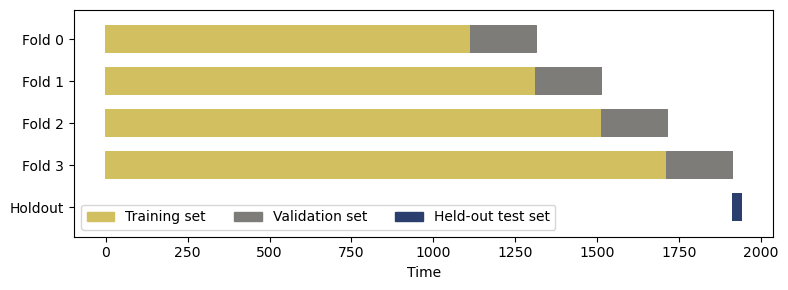

In [68]:
cv_cmap = matplotlib.colormaps["cividis"]
plt.figure(figsize=(8, 3))

for i, (train_mask, valid_mask) in enumerate(cv_folds):
    idx = np.array([np.nan] * time_horizon)
    idx[np.arange(*train_mask)] = 1
    idx[np.arange(*valid_mask)] = 0
    plt.scatter(
        range(time_horizon),
        [i + 0.5] * time_horizon,
        c=idx,
        marker="_",
        capstyle="butt",
        s=1,
        lw=20,
        cmap=cv_cmap,
        vmin=-1.5,
        vmax=1.5,
    )

idx = np.array([np.nan] * time_horizon)
idx[np.arange(*holdout)] = -1
plt.scatter(
    range(time_horizon),
    [n_folds + 0.5] * time_horizon,
    c=idx,
    marker="_",
    capstyle="butt",
    s=1,
    lw=20,
    cmap=cv_cmap,
    vmin=-1.5,
    vmax=1.5,
)

plt.xlabel("Time")
plt.yticks(
    ticks=np.arange(n_folds + 1) + 0.5,
    labels=[f"Fold {i}" for i in range(n_folds)] + ["Holdout"],
)
plt.ylim([len(cv_folds) + 1.2, -0.2])

norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=1.5)
plt.legend(
    [
        Patch(color=cv_cmap(norm(1))),
        Patch(color=cv_cmap(norm(0))),
        Patch(color=cv_cmap(norm(-1))),
    ],
    ["Training set", "Validation set", "Held-out test set"],
    ncol=3,
    loc="best",
)
plt.tight_layout()

### Launch a Dask client on Kubernetes
Let us set up a Dask cluster using the `KubeCluster` class.

In [69]:
cluster = KubeCluster(
    name="rapids-dask",
    image=rapids_image,
    worker_command="dask-cuda-worker",
    n_workers=n_workers,
    resources={"limits": {"nvidia.com/gpu": "1"}},
    env={"EXTRA_PIP_PACKAGES": "optuna gcsfs"},
)

Output()

In [70]:
cluster

Dashboard: http://rapids-dask-scheduler.kubeflow-user-example-com:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.36.0.26:8786,Workers: 0
Dashboard: http://10.36.0.26:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [73]:
client = Client(cluster)
client

<Client: 'tcp://10.36.0.26:8786' processes=1 threads=1, memory=83.48 GiB>

### Define the custom evaluation metric

The M5 forecasting competition defines a custom metric called WRMSSE as follows:

$$
WRMSSE = \sum w_i \cdot RMSSE_i
$$

i.e. WRMSEE is a weighted sum of RMSSE for all product items $i$. RMSSE is in turn defined to be

$$
RMSSE = \sqrt{\frac{1/h \cdot \sum_t{\left(Y_t - \hat{Y}_t\right)}^2}{1/(n-1)\sum_t{(Y_t - Y_{t-1})}^2}}
$$

where the squared error of the prediction (forecast) is normalized by the speed at which the sales amount changes per unit in the training data.

Here is the implementation of the WRMSSE using cuDF. We use the product weights $w_i$ as computed in the first preprocessing notebook.

In [74]:
def wrmsse(product_weights, df, pred_sales, train_mask, valid_mask):
    """Compute WRMSSE metric"""
    df_train = df[(df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])]
    df_valid = df[(df["day_id"] >= valid_mask[0]) & (df["day_id"] < valid_mask[1])]

    # Compute denominator: 1/(n-1) * sum( (y(t) - y(t-1))**2 )
    diff = (
        df_train.sort_values(["item_id", "day_id"])
        .groupby(["item_id"])[["sales"]]
        .diff(1)
    )
    x = (
        df_train[["item_id", "day_id"]]
        .join(diff, how="left")
        .rename(columns={"sales": "diff"})
        .sort_values(["item_id", "day_id"])
    )
    x["diff"] = x["diff"] ** 2
    xx = x.groupby(["item_id"])[["diff"]].agg(["sum", "count"]).sort_index()
    xx.columns = xx.columns.map("_".join)
    xx["denominator"] = xx["diff_sum"] / xx["diff_count"]
    t = xx.reset_index()

    # Compute numerator: 1/h * sum( (y(t) - y_pred(t))**2 )
    X_valid = df_valid.drop(columns=["item_id", "cat_id", "day_id", "sales"])
    if "dept_id" in X_valid.columns:
        X_valid = X_valid.drop(columns=["dept_id"])
    df_pred = cudf.DataFrame(
        {
            "item_id": df_valid["item_id"].copy(),
            "pred_sales": pred_sales,
            "sales": df_valid["sales"].copy(),
        }
    )
    df_pred["diff"] = (df_pred["sales"] - df_pred["pred_sales"]) ** 2
    yy = df_pred.groupby(["item_id"])[["diff"]].agg(["sum", "count"]).sort_index()
    yy.columns = yy.columns.map("_".join)
    yy["numerator"] = yy["diff_sum"] / yy["diff_count"]

    zz = yy[["numerator"]].join(xx[["denominator"]], how="left")
    zz = zz.join(product_weights, how="left").sort_index()
    # Filter out zero denominator.
    # This can occur if the product was never on sale during the period in the training set
    zz = zz[zz["denominator"] != 0]
    zz["rmsse"] = np.sqrt(zz["numerator"] / zz["denominator"])
    t = zz["rmsse"].multiply(zz["weights"])
    return zz["rmsse"].multiply(zz["weights"]).sum()

### Define the training and hyperparameter search pipeline using Optuna
Optuna lets us define the training procedure iteratively, i.e. as if we were to write an ordinary function to train a single model. Instead of a fixed hyperparameter combination, the function now takes in a `trial` object which yields different hyperparameter combinations.

In this example, we partition the training data according to the store and then fit a separate XGBoost model per data segment.

In [75]:
def objective(trial):
    fs = gcsfs.GCSFileSystem()
    with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
        product_weights = cudf.DataFrame(pd.read_pickle(f))
    params = {
        "n_estimators": 100,
        "verbosity": 0,
        "learning_rate": 0.01,
        "objective": "reg:tweedie",
        "tree_method": "gpu_hist",
        "grow_policy": "depthwise",
        "predictor": "gpu_predictor",
        "enable_categorical": True,
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 6, step=1),
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-8, 100, log=True
        ),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1, 2),
    }
    scores = [[] for store in STORES]

    for store_id, store in enumerate(STORES):
        print(f"Processing store {store}...")
        with fs.open(f"{bucket_name}/combined_df_store_{store}.pkl", "rb") as f:
            df = cudf.DataFrame(pd.read_pickle(f))
        for train_mask, valid_mask in cv_folds:
            df_train = df[
                (df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])
            ]
            df_valid = df[
                (df["day_id"] >= valid_mask[0]) & (df["day_id"] < valid_mask[1])
            ]

            X_train, y_train = (
                df_train.drop(
                    columns=["item_id", "dept_id", "cat_id", "day_id", "sales"]
                ),
                df_train["sales"],
            )
            X_valid = df_valid.drop(
                columns=["item_id", "dept_id", "cat_id", "day_id", "sales"]
            )

            clf = xgb.XGBRegressor(**params)
            clf.fit(X_train, y_train)
            pred_sales = clf.predict(X_valid)
            scores[store_id].append(
                wrmsse(product_weights, df, pred_sales, train_mask, valid_mask)
            )
            del df_train, df_valid, X_train, y_train, clf
            gc.collect()
        del df
        gc.collect()

    # We can sum WRMSSE scores over data segments because data segments contain disjoint sets of time series
    return np.array(scores).sum(axis=0).mean()

Using the Dask cluster client, we execute multiple training jobs in parallel. Optuna keeps track of the progress in the hyperparameter search using in-memory Dask storage.

In [76]:
##### Number of hyperparameter combinations to try in parallel
n_trials = 9  # Using a small n_trials so that the demo can finish quickly
# n_trials = 100

# Optimize in parallel on your Dask cluster
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.RandomSampler(seed=0),
    storage=dask_storage,
)
futures = []
for i in range(0, n_trials, n_workers):
    iter_range = (i, min([i + n_workers, n_trials]))
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(
                    # Work around bug https://github.com/optuna/optuna/issues/4859
                    lambda objective, n_trials: (
                        study.sampler.reseed_rng(),
                        study.optimize(objective, n_trials),
                    ),
                    objective,
                    n_trials=1,
                    pure=False,
                )
                for _ in range(*iter_range)
            ],
        }
    )

tstart = time.perf_counter()
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])
    for fut in partition["futures"]:
        _ = fut.result()  # Ensure that the training job was successful
    tnow = time.perf_counter()
    print(
        f"Best cross-validation metric: {study.best_value}, Time elapsed = {tnow - tstart}"
    )
tend = time.perf_counter()
print(f"Total time elapsed = {tend - tstart}")

/tmp/ipykernel_1321/3389696366.py:7: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)


Testing hyperparameter combinations 0..2
Best cross-validation metric: 10.027767173304472, Time elapsed = 331.6198390149948
Testing hyperparameter combinations 2..4
Best cross-validation metric: 9.426913749927916, Time elapsed = 640.7606940959959
Testing hyperparameter combinations 4..6
Best cross-validation metric: 9.426913749927916, Time elapsed = 958.0816706369951
Testing hyperparameter combinations 6..8
Best cross-validation metric: 9.426913749927916, Time elapsed = 1295.700604706988
Testing hyperparameter combinations 8..9
Best cross-validation metric: 8.915009508695244, Time elapsed = 1476.1182343699911
Total time elapsed = 1476.1219055669935


Once the hyperparameter search is complete, we fetch the optimal hyperparameter combination using the attributes of the `study` object.

In [77]:
study.best_params

{'lambda': 2.6232990699579064e-06,
 'alpha': 0.004085800094564677,
 'colsample_bytree': 0.4064535567263888,
 'max_depth': 6,
 'min_child_weight': 9.652128310148716e-08,
 'gamma': 3.4446109254037165e-07,
 'tweedie_variance_power': 1.0914258082324833}

In [78]:
study.best_trial

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[8.915009508695244], datetime_start=datetime.datetime(2023, 9, 28, 19, 35, 29, 888497), datetime_complete=datetime.datetime(2023, 9, 28, 19, 38, 30, 299541), params={'lambda': 2.6232990699579064e-06, 'alpha': 0.004085800094564677, 'colsample_bytree': 0.4064535567263888, 'max_depth': 6, 'min_child_weight': 9.652128310148716e-08, 'gamma': 3.4446109254037165e-07, 'tweedie_variance_power': 1.0914258082324833}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=100.0, log=True, low=1e-08, step=None), 'alpha': FloatDistribution(high=100.0, log=True, low=1e-08, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.2, step=None), 'max_depth': IntDistribution(high=6, log=False, low=2, step=1), 'min_child_weight': FloatDistribution(high=100.0, log=True, low=1e-08, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'tweedie_variance_pow

In [79]:
# Make a deep copy to preserve the dictionary after deleting the Dask cluster
best_params = copy.deepcopy(study.best_params)
best_params

{'lambda': 2.6232990699579064e-06,
 'alpha': 0.004085800094564677,
 'colsample_bytree': 0.4064535567263888,
 'max_depth': 6,
 'min_child_weight': 9.652128310148716e-08,
 'gamma': 3.4446109254037165e-07,
 'tweedie_variance_power': 1.0914258082324833}

In [80]:
fs = gcsfs.GCSFileSystem()
with fs.open(f"{bucket_name}/params.json", "w") as f:
    json.dump(best_params, f)

### Train the final XGBoost model and evaluate
Using the optimal hyperparameters found in the search, fit a new model using the whole training data. As in the previous section, we fit a separate XGBoost model per data segment.

In [81]:
fs = gcsfs.GCSFileSystem()
with fs.open(f"{bucket_name}/params.json", "r") as f:
    best_params = json.load(f)
with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
    product_weights = cudf.DataFrame(pd.read_pickle(f))

In [82]:
def final_train(best_params):
    fs = gcsfs.GCSFileSystem()
    params = {
        "n_estimators": 100,
        "verbosity": 0,
        "learning_rate": 0.01,
        "objective": "reg:tweedie",
        "tree_method": "gpu_hist",
        "grow_policy": "depthwise",
        "predictor": "gpu_predictor",
        "enable_categorical": True,
    }
    params.update(best_params)
    model = {}
    train_mask = [0, 1914]

    for store in STORES:
        print(f"Processing store {store}...")
        with fs.open(f"{bucket_name}/combined_df_store_{store}.pkl", "rb") as f:
            df = cudf.DataFrame(pd.read_pickle(f))

        df_train = df[(df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])]
        X_train, y_train = (
            df_train.drop(columns=["item_id", "dept_id", "cat_id", "day_id", "sales"]),
            df_train["sales"],
        )

        clf = xgb.XGBRegressor(**params)
        clf.fit(X_train, y_train)
        model[store] = clf
    del df
    gc.collect()

    return model

In [83]:
model = final_train(best_params)

Processing store CA_1...
Processing store CA_2...
Processing store CA_3...
Processing store CA_4...
Processing store TX_1...
Processing store TX_2...
Processing store TX_3...
Processing store WI_1...
Processing store WI_2...
Processing store WI_3...


Let's now evaluate the final model using the held-out test set:

In [84]:
test_wrmsse = 0
for store in STORES:
    with fs.open(f"{bucket_name}/combined_df_store_{store}.pkl", "rb") as f:
        df = cudf.DataFrame(pd.read_pickle(f))
    df_test = df[(df["day_id"] >= holdout[0]) & (df["day_id"] < holdout[1])]
    X_test = df_test.drop(columns=["item_id", "dept_id", "cat_id", "day_id", "sales"])
    pred_sales = model[store].predict(X_test)
    test_wrmsse += wrmsse(
        product_weights, df, pred_sales, train_mask=[0, 1914], valid_mask=holdout
    )
print(f"WRMSSE metric on the held-out test set: {test_wrmsse}")

WRMSSE metric on the held-out test set: 9.478942050051291


In [85]:
# Save the model to the Cloud Storage
with fs.open(f"{bucket_name}/final_model.pkl", "wb") as f:
    pickle.dump(model, f)

## Create an ensemble model using a different strategy for segmenting sales data
It is common to create an ensemble model where multiple machine learning methods are used to obtain better predictive performance. Prediction is made from an ensemble model by averaging the prediction output of the constituent models.

In this example, we will create a second model by segmenting the sales data in a different way. Instead of splitting by stores, we will split the data by both stores and product categories.

In [86]:
def objective_alt(trial):
    fs = gcsfs.GCSFileSystem()
    with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
        product_weights = cudf.DataFrame(pd.read_pickle(f))
    params = {
        "n_estimators": 100,
        "verbosity": 0,
        "learning_rate": 0.01,
        "objective": "reg:tweedie",
        "tree_method": "gpu_hist",
        "grow_policy": "depthwise",
        "predictor": "gpu_predictor",
        "enable_categorical": True,
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 6, step=1),
        "min_child_weight": trial.suggest_float(
            "min_child_weight", 1e-8, 100, log=True
        ),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1, 2),
    }
    scores = [[] for i in range(len(STORES) * len(DEPTS))]

    for store_id, store in enumerate(STORES):
        for dept_id, dept in enumerate(DEPTS):
            print(f"Processing store {store}, department {dept}...")
            with fs.open(
                f"{bucket_name}/combined_df_store_{store}_dept_{dept}.pkl", "rb"
            ) as f:
                df = cudf.DataFrame(pd.read_pickle(f))
            for train_mask, valid_mask in cv_folds:
                df_train = df[
                    (df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])
                ]
                df_valid = df[
                    (df["day_id"] >= valid_mask[0]) & (df["day_id"] < valid_mask[1])
                ]

                X_train, y_train = (
                    df_train.drop(columns=["item_id", "cat_id", "day_id", "sales"]),
                    df_train["sales"],
                )
                X_valid = df_valid.drop(
                    columns=["item_id", "cat_id", "day_id", "sales"]
                )

                clf = xgb.XGBRegressor(**params)
                clf.fit(X_train, y_train)
                sales_pred = clf.predict(X_valid)
                scores[store_id * len(DEPTS) + dept_id].append(
                    wrmsse(product_weights, df, sales_pred, train_mask, valid_mask)
                )
                del df_train, df_valid, X_train, y_train, clf
                gc.collect()
            del df
            gc.collect()

    # We can sum WRMSSE scores over data segments because data segments contain disjoint sets of time series
    return np.array(scores).sum(axis=0).mean()

In [87]:
##### Number of hyperparameter combinations to try in parallel
n_trials = 9  # Using a small n_trials so that the demo can finish quickly
# n_trials = 100

# Optimize in parallel on your Dask cluster
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.RandomSampler(seed=0),
    storage=dask_storage,
)
futures = []
for i in range(0, n_trials, n_workers):
    iter_range = (i, min([i + n_workers, n_trials]))
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(
                    # Work around bug https://github.com/optuna/optuna/issues/4859
                    lambda objective, n_trials: (
                        study.sampler.reseed_rng(),
                        study.optimize(objective, n_trials),
                    ),
                    objective_alt,
                    n_trials=1,
                    pure=False,
                )
                for _ in range(*iter_range)
            ],
        }
    )

tstart = time.perf_counter()
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])
    for fut in partition["futures"]:
        _ = fut.result()  # Ensure that the training job was successful
    tnow = time.perf_counter()
    print(
        f"Best cross-validation metric: {study.best_value}, Time elapsed = {tnow - tstart}"
    )
tend = time.perf_counter()
print(f"Total time elapsed = {tend - tstart}")

/tmp/ipykernel_1321/491731696.py:7: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)


Testing hyperparameter combinations 0..2
Best cross-validation metric: 9.896445497438858, Time elapsed = 802.2191872399999
Testing hyperparameter combinations 2..4
Best cross-validation metric: 9.896445497438858, Time elapsed = 1494.0718872279976
Testing hyperparameter combinations 4..6
Best cross-validation metric: 9.835407407395302, Time elapsed = 2393.3159628150024
Testing hyperparameter combinations 6..8
Best cross-validation metric: 9.330048901795887, Time elapsed = 3092.471466117
Testing hyperparameter combinations 8..9
Best cross-validation metric: 9.330048901795887, Time elapsed = 3459.9082761530008
Total time elapsed = 3459.911843854992


In [88]:
# Make a deep copy to preserve the dictionary after deleting the Dask cluster
best_params_alt = copy.deepcopy(study.best_params)
best_params_alt

{'lambda': 0.028794929327421122,
 'alpha': 3.3150619134761685e-07,
 'colsample_bytree': 0.42330433646728755,
 'max_depth': 2,
 'min_child_weight': 0.09713314395591004,
 'gamma': 0.0016337599227941016,
 'tweedie_variance_power': 1.1915217521234043}

In [89]:
fs = gcsfs.GCSFileSystem()
with fs.open(f"{bucket_name}/params_alt.json", "w") as f:
    json.dump(best_params_alt, f)

Using the optimal hyperparameters found in the search, fit a new model using the whole training data.

In [90]:
def final_train_alt(best_params):
    fs = gcsfs.GCSFileSystem()
    with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
        product_weights = cudf.DataFrame(pd.read_pickle(f))
    params = {
        "n_estimators": 100,
        "verbosity": 0,
        "learning_rate": 0.01,
        "objective": "reg:tweedie",
        "tree_method": "gpu_hist",
        "grow_policy": "depthwise",
        "predictor": "gpu_predictor",
        "enable_categorical": True,
    }
    params.update(best_params)
    model = {}
    train_mask = [0, 1914]

    for _, store in enumerate(STORES):
        for _, dept in enumerate(DEPTS):
            print(f"Processing store {store}, department {dept}...")
            with fs.open(
                f"{bucket_name}/combined_df_store_{store}_dept_{dept}.pkl", "rb"
            ) as f:
                df = cudf.DataFrame(pd.read_pickle(f))
            for train_mask, _ in cv_folds:
                df_train = df[
                    (df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])
                ]
                X_train, y_train = (
                    df_train.drop(columns=["item_id", "cat_id", "day_id", "sales"]),
                    df_train["sales"],
                )

                clf = xgb.XGBRegressor(**params)
                clf.fit(X_train, y_train)
                model[(store, dept)] = clf
            del df
            gc.collect()

    return model

In [91]:
fs = gcsfs.GCSFileSystem()
with fs.open(f"{bucket_name}/params_alt.json", "r") as f:
    best_params_alt = json.load(f)
with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
    product_weights = cudf.DataFrame(pd.read_pickle(f))

In [92]:
model_alt = final_train_alt(best_params_alt)

Processing store CA_1, department HOBBIES_1...
Processing store CA_1, department HOBBIES_2...
Processing store CA_1, department HOUSEHOLD_1...
Processing store CA_1, department HOUSEHOLD_2...
Processing store CA_1, department FOODS_1...
Processing store CA_1, department FOODS_2...
Processing store CA_1, department FOODS_3...
Processing store CA_2, department HOBBIES_1...
Processing store CA_2, department HOBBIES_2...
Processing store CA_2, department HOUSEHOLD_1...
Processing store CA_2, department HOUSEHOLD_2...
Processing store CA_2, department FOODS_1...
Processing store CA_2, department FOODS_2...
Processing store CA_2, department FOODS_3...
Processing store CA_3, department HOBBIES_1...
Processing store CA_3, department HOBBIES_2...
Processing store CA_3, department HOUSEHOLD_1...
Processing store CA_3, department HOUSEHOLD_2...
Processing store CA_3, department FOODS_1...
Processing store CA_3, department FOODS_2...
Processing store CA_3, department FOODS_3...
Processing store CA

In [93]:
# Save the model to the Cloud Storage
with fs.open(f"{bucket_name}/final_model_alt.pkl", "wb") as f:
    pickle.dump(model_alt, f)

Now consider an ensemble consisting of the two models `model` and `model_alt`. We evaluate the ensemble by computing the WRMSSE metric for the average of the predictions of the two models.

In [94]:
test_wrmsse = 0
for store in STORES:
    print(f"Processing store {store}...")
    # Prediction from Model 1
    with fs.open(f"{bucket_name}/combined_df_store_{store}.pkl", "rb") as f:
        df = cudf.DataFrame(pd.read_pickle(f))
    df_test = df[(df["day_id"] >= holdout[0]) & (df["day_id"] < holdout[1])]
    X_test = df_test.drop(columns=["item_id", "dept_id", "cat_id", "day_id", "sales"])
    df_test["pred1"] = model[store].predict(X_test)

    # Prediction from Model 2
    df_test["pred2"] = [np.nan] * len(df_test)
    df_test["pred2"] = df_test["pred2"].astype("float32")
    for dept in DEPTS:
        with fs.open(
            f"{bucket_name}/combined_df_store_{store}_dept_{dept}.pkl", "rb"
        ) as f:
            df2 = cudf.DataFrame(pd.read_pickle(f))
        df2_test = df2[(df2["day_id"] >= holdout[0]) & (df2["day_id"] < holdout[1])]
        X_test = df2_test.drop(columns=["item_id", "cat_id", "day_id", "sales"])
        assert np.sum(df_test["dept_id"] == dept) == len(X_test)
        df_test["pred2"][df_test["dept_id"] == dept] = model_alt[(store, dept)].predict(
            X_test
        )

    # Average prediction
    df_test["avg_pred"] = (df_test["pred1"] + df_test["pred2"]) / 2.0

    test_wrmsse += wrmsse(
        product_weights,
        df,
        df_test["avg_pred"],
        train_mask=[0, 1914],
        valid_mask=holdout,
    )
print(f"WRMSSE metric on the held-out test set: {test_wrmsse}")

Processing store CA_1...
Processing store CA_2...
Processing store CA_3...
Processing store CA_4...
Processing store TX_1...
Processing store TX_2...
Processing store TX_3...
Processing store WI_1...
Processing store WI_2...
Processing store WI_3...
WRMSSE metric on the held-out test set: 10.69187847848366


In [95]:
# Close the Dask cluster to clean up
cluster.close()

## Conclusion

We demonstrated an end-to-end workflow where we take a real-world time-series data and train a forecasting model using Google Kubernetes Engine (GKE). We were able to speed up the hyperparameter optimization (HPO) process by dispatching parallel training jobs to NVIDIA GPUs.